In [30]:
from math import log2,inf
from math import comb as binom
import itertools

### Combinatorial Approach

In [22]:
#cost for MitM within the combinatorial NTRU attack, where the two lists are each of size L
def cost_mitm(L,n,q,weight_g,verb=0,packed=0):
    T=inf
    for l in range(1,30):
        if not(packed):
            tmp=max(2+log2(l)+L,2*L-log2(q)*l+log2(l*n))+log2(1/(1-w_g/n))*l+log2(q)*2
        else:
            tmp=max(log2(20)+log2(l)+L,2*L-log2(q)*l+log2(l*n))+log2(1/(1-w_g/n))*l+log2(q)*2
        if tmp<T:
            lval=l
            T=tmp
    if verb:
        return T,lval
    return T

In [23]:
#Packed and unpacked complexity in error model
def packed_mitm_error(n,q,w_g,p,verb=0,asym=0):
    if not(asym):
        L=log2(binom(ceil(n/5*8/2),ceil(n/5*8/2*p)))
    else:
        L=log2(binom(ceil((0.5+p/2)*n/5*8/2),ceil(0.5*n/5*8/2*p)))
    return cost_mitm(L,n,q,w_g,verb=verb,packed=1)

def unpacked_mitm_error(n,q,w_g,p,verb=0,asym=0):
    if not(asym):
        L=log2(binom(ceil(n),ceil(n*p)))
    else:
        k=2/3*n*(1-p)
        L=log2(binom(ceil((n-k)),ceil((n-k)*p)))
    return cost_mitm(L,n,q,w_g,verb=verb)

In [24]:
#Packed and unpacked complexity in erasure model
def packed_mitm_erasure(n,q,w_g,erasures,verb=0):
    L=erasures/2
    T=cost_mitm(L,n,q,w_g,verb=verb,packed=1)
    return T

def unpacked_mitm_erasure(n,q,w_g,w_f,p,verb=0):
    L=(2*2*p*(1-p)/3+p^2*log2(3))*(n-1)
    return cost_mitm(L/2,n,q,w_g,verb=verb)

### Lattice-based Approach

Make Sure the lwe-estimator is located in the same folder as this file, i.e., you cloned the lwe estimator repository (https://bitbucket.org/malb/lwe-estimator) into "./lwe-estimator"
such that the command 

`load("./lwe-estimator/estimator.py")` 

does not fail

In [25]:
load("./lwe-estimator/estimator.py")

#calculates complexity of given 
def lwe_complexity(n,q,w_secret,w_error,samples,accuracy=1,err=0):
    norm = sqrt(w_error)
    sd = norm/sqrt(n)
    alpha = sqrt(2*pi)*sd/RR(q)
    m = samples
    if not(err):
        secret_distribution = ((-1,1),w_secret) # erasure model
    else:
        secret_distribution = ((-2,2),w_secret) # error model
    success_probability = 0.99
    if accuracy:
        reduction_cost_model =  BKZ.BDGL16
    else:
        reduction_cost_model =  lambda beta, d, B: BKZ.LLL(d, B) +ZZ(2)**RR(0.3496 * beta + 16.4 + log(BKZ.svp_repeat(beta, d), 2))

    primald = partial(drop_and_solve, primal_usvp, postprocess=False, decision=False)
    if n>20:
        cost = primald(n, alpha, q, secret_distribution=secret_distribution, m=samples,     success_probability=success_probability,    reduction_cost_model=reduction_cost_model)
    else:
        cost=primal_usvp(n, alpha, q, secret_distribution=secret_distribution, m=samples,     success_probability=success_probability,    reduction_cost_model=reduction_cost_model)

    return log2(cost["rop"])


In [26]:
def lattice_erasure_unpacked(n,q,w_f,w_g,p):
    pq=p/3*(4-p)
    k=max(5,round(pq*n))
    weight_secret=max(2,round(2*k/3))
    if k<20:
        return k
    return lwe_complexity(k,q,weight_secret,round(w_g*k/n),n,accuracy=0)

def lattice_erasure_packed(n,q,w_f,w_g,p):
    erasure=[3.03,4.23,4.69,4.88,4.96,4.99,5,5]
    t=0
    for i in range(1,9):
        t+=(binom(8,i)*p^i*(1-p)^(8-i)*ceil(n/5)*erasure[i-1])
    
    weight_secret=max(2,(ceil(t*2/3)))
    t=round(max(5,t))
    if t<20:
        return 0
    return lwe_complexity(t,q,weight_secret,round(w_g*t/n),n,accuracy=0)


In [27]:
def lattice_error_unpacked(n,q,w_f,w_g,p,asym=0):
    pq=2*p-p^2
    if not(asym):
        k=n
        weight_error=w_g
        weight_secret=min(k-1,max(2,round(pq*n)))
        error21=1
    else:
        k=max(2,round(n/3*(1+2*p)))
        weight_error=max(2,int(round(w_g*k/n)))
        weight_secret=max(2,int(round(2*n/3*p)))
        error21=0
    
    k=max(2,k)
    return lwe_complexity(k,q,weight_secret,weight_error,n,accuracy=0,err=error21)

def lattice_error_packed(n,q,w_f,w_g,p):
    erasure=[3.02,3.06,3.44,3.37,3.44,3.42,3.42,3.39]
    t=0
    for i in range(1,9):
        t+=round(binom(8,i)*p^i*(1-p)^(8-i)*n/5*erasure[i-1])
    weight_secret=max(2,int(t))
    return lwe_complexity(n,q,weight_secret,w_g,n,accuracy=0,err=1)

#### Choose parameter set 

In [31]:
n=509
q=2048
w_g=q/8-2
w_f=(2*n-1)/3

In [1950]:
n=677
q=2048
w_g=q/8-2
w_f=(2*n-1)/3

In [1964]:
n=821
q=4096
w_g=q/8-2
w_f=(2*n-1)/3

### Calculate complexity of combinatorial attacks

In [47]:
#combinatorial attacks
L_erasure_packed=[]
L_erasure_unpacked=[]
L_erasure_unpacked_no_simulate=[]
L_packed_error_asym=[]
L_packed_error_sym=[]
L_unpacked_error_sym=[]
L_unpacked_error_asym=[]
p1=0.001
while p1<1:
    L_erasure_packed.append([p1,packed_mitm_erasure(n,q,w_g,p1*n/5*8)])
    L_erasure_unpacked.append([p1,unpacked_mitm_erasure(n,q,w_g,w_f,p1)])
    L_erasure_unpacked_no_simulate.append([p1,unpacked_mitm_erasure_no_simulate(n,q,w_g,w_f,p1)])    
    L_packed_error_asym.append([p1,packed_mitm_error(n,q,w_g,p1,asym=1)])
    L_packed_error_sym.append([p1,packed_mitm_error(n,q,w_g,p1,asym=0)])
    L_unpacked_error_sym.append([p1,unpacked_mitm_error(n,q,w_g,p1,asym=0)])
    L_unpacked_error_asym.append([p1,unpacked_mitm_error(n,q,w_g,p1,asym=1)])
    p1+=0.001

### Calculate complexity of lattice erasure attack

In [33]:
#Lattice Erasure
L_lattice_erasure_packed=[]
L_lattice_erasure_unpacked=[]
p1=0.001
while p1<1:
    L_lattice_erasure_packed.append([p1,lattice_erasure_packed(n,q,w_f,w_g,p1)])
    L_lattice_erasure_unpacked.append([p1,lattice_erasure_unpacked(n,q,w_f,w_g,p1)])
    p1+=0.005


### Calculate complexity of lattice symmetric error attacks

In [34]:
#Lattice Error Sym
L_lattice_error_packed_sym=[]
L_lattice_error_unpacked_sym=[]
p1=0.001
while p1<0.2:
    L_lattice_error_packed_sym.append([p1,lattice_error_packed(n,q,w_f,w_g,p1)])
    L_lattice_error_unpacked_sym.append([p1,lattice_error_unpacked(n,q,w_f,w_g,p1,asym=0)])
    p1+=0.001


### Calculate complexity of lattice asymmetric error attacks

In [35]:
#Lattice Error Asym
L_lattice_error_packed_asym=[]
L_lattice_error_unpacked_asym=[]
p1=0.001

while p1<1:

    L_lattice_error_packed_asym.append([p1,lattice_error_packed(n,q,w_f,w_g,p1)])
    L_lattice_error_unpacked_asym.append([p1,lattice_error_unpacked(n,q,w_f,w_g,p1,asym=1)])
    if p1<0.2:
        p1+=0.001
    else:
        p1+=0.05



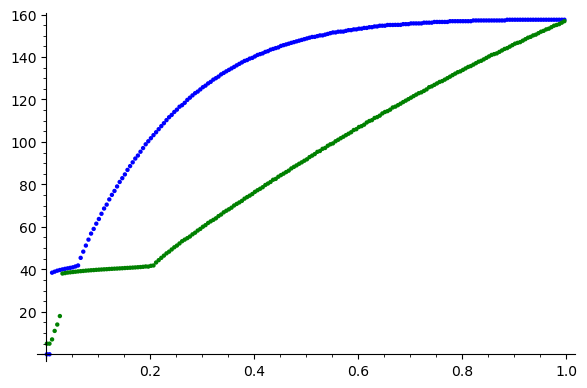

In [49]:
list_plot(L_lattice_erasure_packed)+list_plot(L_lattice_erasure_unpacked,color="green")

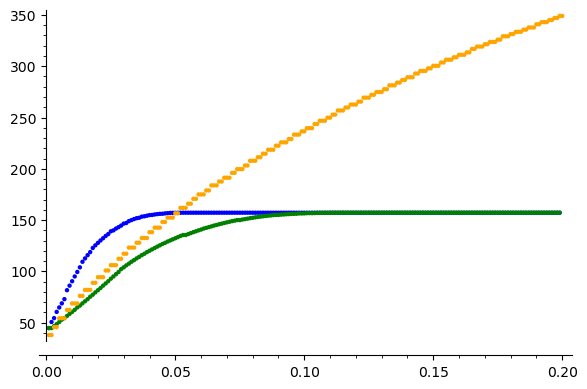

In [50]:
rang=200
list_plot(L_lattice_error_packed_sym[:rang])+list_plot(L_lattice_error_unpacked_sym[:rang],color="green")+list_plot(L_packed_error_sym[:rang],color="orange")

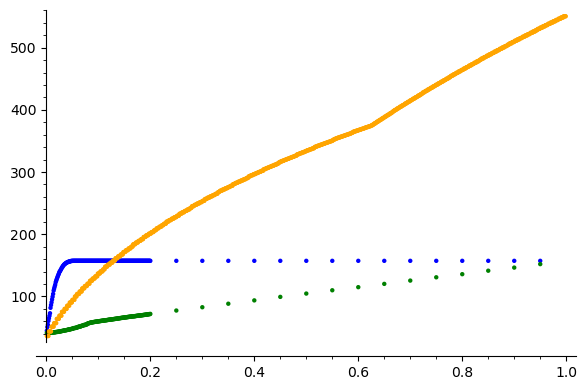

In [51]:
rang=5000
list_plot(L_lattice_error_packed_asym[:rang])+list_plot(L_lattice_error_unpacked_asym[:rang],color="green")+list_plot(L_packed_error_asym[:rang],color="orange")

### Calculate NTRU expected error / erasure when converting from packed to unpacked format

In [56]:
# C(#S, m)
def findsubsets(S,m):
    return set(itertools.combinations(S, m))

# erasure

prob_erasure = [[0.0 for j in range(6)] for i in range(8)]
# setup
S = {0,1,2,3,4,5,6,7}

for k in range(1,9,1):

    MS = findsubsets(S, k); # #S choose k

    array_diff = [0 for i in range(6)];

    for num in range(243): # 3**5 possibilities with 5 many F_3 elements
        for flip in MS: # over all possible C(8,k) choices

            num_vary = [num for i in range(2**k)]
            for i in range(2**k): # flip the k many bits (enumerate all possibilities)
                v = i;
                for j in range(k):
                    num_vary[i] = num_vary[i] ^^ (v%2)*(2**flip[j])
                    v = v>>1;

            # compare w.r.t field representation
            num_diff = 0;
            for iter in range(5):
                for i in range(2**k):
                    if (num_vary[0]%3) != (num_vary[i]%3):
                        num_diff += 1;
                        break;
                for i in range(2**k):
                    num_vary[i] = num_vary[i]//3

            array_diff[num_diff] += 1;

    prob_erasure[k-1] = [array_diff[i]/sum(array_diff) for i in range(6)]

exp_erasure = [0.0 for i in range(8)]
for i in range(8):
    for j in range(5):
        exp_erasure[i] += prob_erasure[i][j+1]*(j+1)
print(exp_erasure)


# symmetric error

prob_error_sym = [[0.0 for j in range(6)] for i in range(8)]
# setup
S = {0,1,2,3,4,5,6,7}

for k in range(1,9,1):
    
    MS = findsubsets(S, k); # #S choose k

    array_diff = [0 for i in range(6)];

    for num in range(243): # 3**5 possibilities with 5 many F_3 elements
        for flip in MS: # over all possible C(8,k) choices

            num_vary = [num for i in range(2)]
            for j in range(k): # flip the k many bits
                num_vary[1] = num_vary[1] ^^ (2**flip[j])

            # compare w.r.t field representation
            num_diff = 0;
            for iter in range(5):
                if (num_vary[0]%3) != (num_vary[1]%3):
                    num_diff += 1;
                for i in range(2):
                    num_vary[i] = num_vary[i]//3

            array_diff[num_diff] += 1;

    prob_error_sym[k-1] = [array_diff[i]/sum(array_diff) for i in range(6)]

exp_error_sym = [0.0 for i in range(8)]
for i in range(8):
    for j in range(5):
        exp_error_sym[i] += prob_error_sym[i][j+1]*(j+1)
print(exp_error_sym)


[3.02829218106996, 4.22648442092887, 4.68577307466196, 4.87771898883010, 4.96002351557907, 4.99059376837155, 5.00000000000000, 5.00000000000000]
[3.02829218106996, 3.06158142269253, 3.43489124044680, 3.35114638447972, 3.41740152851264, 3.38286302175191, 3.37757201646091, 3.33333333333333]
